# UNet model

Running the UNet from here 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
# import skorch
import torchvision.datasets as dset
import torchvision.models as models
import collections
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.transforms as transforms
from tqdm import tqdm

%matplotlib inline

from optparse import OptionParser
from unet import UNet
from utils import *
from myloss import dice_coeff

from skimage.filters import threshold_otsu, rank

import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from UNet_Loader import ILDDataset

/home/magdy/cs231n_bmi260_project/Pytorch-UNet/utils/data_vis.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.

In [4]:
NUM_TOTAL = 830
NUM_TRAIN = 700

lung_dataset_train = ILDDataset(cystic_path='../../Cystic_masks_new/Train',
                          root_dir='../../Cystic Dataset/Train',
                          mask=True, HU=True, resize=512)

lung_dataset_test = ILDDataset(cystic_path='../../Cystic_masks_new/Test',
                          root_dir='../../Cystic Dataset/Test',
                          mask=True, HU=True, resize=512)

loader_train = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=1)

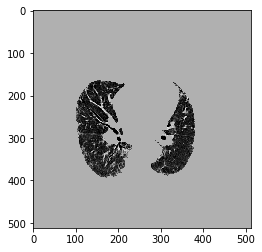

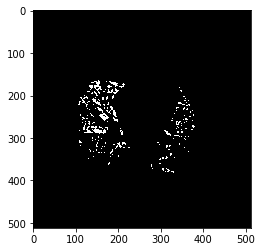

In [5]:
#data sample
sample = lung_dataset_train[23]
plt.imshow(sample[0], cmap="gray")
plt.show()
plt.imshow(sample[1], cmap="gray")
plt.show()

In [6]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Check Accuracy

In [7]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return ((2. * intersection ) / (A_sum + B_sum ) )

In [11]:
def eval_net(net, loader, device, gpu=True):
    if loader.dataset.train:
        print('Checking accuracy on training set')
    else:
        print('Checking accuracy on val/test set')   

    tot = 0
    ADCS_Avg = 0
    cntr = 0
    net.eval()
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            if gpu:
                net.cuda()
                X = Variable(X, requires_grad=True).cuda()
                y = Variable(y, requires_grad=True).cuda()
            else:
                X = Variable(X, requires_grad=True)
                y = Variable(y, requires_grad=True)

            X.unsqueeze_(1)
            y.unsqueeze_(1)
            y_pred = net(X)


            probs = F.sigmoid(y_pred)
            y_pred_print = (probs > 0.5)
            dice = dice_loss(y_pred_print.float(), y)
            pred_cyst_score = np.sum(y_pred_print.cpu().numpy())/np.sum((X.cpu().numpy()>0))
            act_cyst_score = np.sum(y.cpu().numpy())/np.sum((X.cpu().numpy()>0))
            ADCS = np.absolute((pred_cyst_score-act_cyst_score)/act_cyst_score)
        
            tot += dice
            ADCS_Avg += ADCS
            cntr += 1
            
            if 0:
                X = X.data.squeeze(1).cpu().numpy()
                X = np.transpose(X, axes=[1, 2, 0])
                y = y.data.squeeze(1).cpu().numpy()
                y = np.transpose(y, axes=[1, 2, 0])
                y_pred = y_pred.data.squeeze(1).squeeze(1).cpu().numpy()
                y_pred = np.transpose(y_pred, axes=[1, 2, 0])

                
                print("X")
                plt.imshow(X[:,:,0], cmap='gray')
                plt.show()
                
                print("Print Y")
                plt.imshow(y_pred_print[0,0,:,:], cmap='gray')
                plt.show()
                
                print("Actual Y")
                plt.imshow(y[:,:,0], cmap='gray')        
                plt.show()
                
                print("dice score: ", dice)
                
    return tot / cntr, ADCS_Avg / cntr

# Train

In [7]:
#Train function

def train_net(net, epochs=50, batch_size=4, lr=1e-3, save=True, gpu=True):
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)

    weights = torch.tensor([30, 1], device= device, dtype=dtype)
#     criterion = weighted_binary_cross_entropy(weight=weights)
    criterion = nn.BCELoss()
    dir_checkpoint = 'checkpoints/'
    
    all_losses = []
    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))

        epoch_loss = 0
            
        for t, (X, y) in enumerate(loader_train):
            X = X.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            X.unsqueeze_(1)
            y.unsqueeze_(1)

            if gpu:
                net.cuda()
                X = Variable(X).cuda()
                y = Variable(y).cuda()
            else:
                X = Variable(X)
                y = Variable(y)
            
            
            y_pred = net(X)
#             print(y_pred.shape)
            
            probs = F.sigmoid(y_pred)
            thresh = threshold_otsu(probs.data.cpu().numpy())
            probs_flat = probs.view(-1)
            y_pred_print = (probs > thresh)
            y_flat = y.view(-1)

            loss = criterion(probs_flat, y_flat.float())
            all_losses.append(loss)
            epoch_loss += loss.data[0]

            if(t%100 == 0):
                print('{0:.4f} --- loss: {1:.6f}'.format(t,
                                                     loss.data[0]))
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / t))
        
        if 1:
            val_dice = eval_net(net, loader_val, device, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))
        if 0:
            print("X")
            plt.imshow(X.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Predicted Y")
            plt.imshow(y_pred.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Probs Y")
            plt.imshow(probs.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Print Y")
            plt.imshow(y_pred_print.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Actual Y")
            plt.imshow(y.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
#             _ = plt.hist(probs.data.cpu().numpy().reshape([-1]), 1000)
#             plt.ylim([0, 500])
#             plt.plot([thresh, thresh], [0, 500], 'r')
#             plt.show()

        if save:
            torch.save(net.state_dict(),
                       dir_checkpoint + '/batch_adam/CP{}.pth'.format(epoch))

            print('Checkpoint {} saved !'.format(epoch))
            
    return all_losses


In [8]:
net = UNet(1, 1)
# net.load_state_dict(torch.load('checkpoints/batch_04/CP49.pth'))
try:
    all_losses = train_net(net) # , options.epochs, options.batchsize, options.lr,gpu=options.gpu)
    np.save('all_losses.pkl', all_losses)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')

Starting epoch 1/50.
0.0000 --- loss: 0.657654
100.0000 --- loss: 0.149213
Epoch finished ! Loss: 0.22011864185333252
Checking accuracy on val/test set
Validation Dice Coeff: 0.19613710045814514
Checkpoint 0 saved !
Starting epoch 2/50.
0.0000 --- loss: 0.080305
100.0000 --- loss: 0.080374
Epoch finished ! Loss: 0.05701831728219986
Checking accuracy on val/test set
Validation Dice Coeff: 0.20843340456485748
Checkpoint 1 saved !
Starting epoch 3/50.
0.0000 --- loss: 0.053378
100.0000 --- loss: 0.033619
Epoch finished ! Loss: 0.04858822003006935
Checking accuracy on val/test set
Validation Dice Coeff: 0.4465096592903137
Checkpoint 2 saved !
Starting epoch 4/50.
0.0000 --- loss: 0.046429
100.0000 --- loss: 0.100867
Epoch finished ! Loss: 0.04843562841415405
Checking accuracy on val/test set
Validation Dice Coeff: 0.8947023153305054
Checkpoint 3 saved !
Starting epoch 5/50.
0.0000 --- loss: 0.018593
100.0000 --- loss: 0.035526
Epoch finished ! Loss: 0.044278521090745926
Checking accuracy o

In [13]:
net = UNet(1, 1)
net.load_state_dict(torch.load('checkpoints/batch_adam/CP47.pth'))

In [14]:
val_dice, adcs = eval_net(net, loader_val, device, True)
print("Val dice:", val_dice)
print("Val ADCS:", adcs)

Checking accuracy on val/test set
Val dice: tensor(0.8071, device='cuda:0')
Val ADCS: 0.24202368777959077
